# Load the data 

In [1]:
from DS_MIMIC_knn import *

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import dask as dd
import seaborn as sns

In [3]:
admissions = pd.read_csv('../data/core/admissions.csv')
patients = pd.read_csv('../data/core/patients.csv')
diagnose = pd.read_csv('../data/hosp/d_icd_diagnoses.csv')
subj_diagnose = pd.read_csv('../data/hosp/diagnoses_icd.csv')
icu_stays = pd.read_csv('../data/icu/icustays.csv')

# Select the Cohort 
Here we select the patients dignosed with ICH from the whole hospital addmission. The corresponding ICD codes are 'I61*' (ICD-10) and '431*' (ICD-9). 


Then we filter the patients who were addmitteed to the intensive care unit. 

In [4]:
icu_ids = icu_stays['subject_id'].unique()

In [5]:
def get_icu_cohort(icd10,icd9):
    df1=patients.set_index('subject_id')
    df_icd10=subj_diagnose[subj_diagnose['icd_code'].str.contains(str(icd10))]
    df_icd9 = subj_diagnose[subj_diagnose['icd_code'].str.contains(str(icd9))]
    df_icdall=pd.concat([df_icd9,df_icd10]).drop_duplicates('subject_id', keep='first')
    df_icu = df_icdall[df_icdall['subject_id'].isin(icu_ids)].set_index('subject_id')
    data = df_icu.join(df1,how='left')
    data['dod']=data['dod'].replace(np.nan, 0, regex=True)
    data['dod']=data['dod'].replace('-', 1, regex=True)

    return data

def mortality_rate(df):
    return np.count_nonzero(df['dod']==1)/len(df['dod'])

In [6]:
cohort = get_icu_cohort('I61',r'^431')
print('cohort size', cohort.shape[0])
print('mortality_rate', mortality_rate(cohort))
cohort

cohort size 2485
mortality_rate 0.2784708249496982


,hadm_id,seq_num,icd_code,icd_version,gender,anchor_age,anchor_year,anchor_year_group,dod
subject_id,,,,,,,,,
12116269,24214849,2,431,9,M,66,2166,2008 - 2010,0
12155595,26672436,2,431,9,F,52,2168,2008 - 2010,0
19620109,26497452,2,431,9,F,66,2128,2008 - 2010,0
19330004,20802265,1,431,9,M,52,2187,2008 - 2010,0
18414729,22609366,2,431,9,F,60,2152,2008 - 2010,0
...,...,...,...,...,...,...,...,...,...
14050724,20952526,1,I615,10,F,57,2112,2011 - 2013,0
12557389,21294125,1,I613,10,F,79,2151,2017 - 2019,0
18065731,25556934,1,I618,10,M,46,2137,2011 - 2013,0


# Select Features

In [7]:
def get_data(cohort_index, data_table, index_colname):
    return data_table[data_table[index_colname].isin(cohort_index)]

In [8]:
def fill_na_mean(df, rd=2, inplace=True):
    for col in list(df.columns[df.isnull().sum() > 0]):
        mean_val = df[col].mean()
        if inplace:
            try:
                df[col].fillna(round(mean_val,rd),inplace=inplace)
            except TypeError:
                continue
        else:
            try:
                df = df[col].fillna(round(mean_val,rd))
            except TypeError:
                continue
    if not inplace:
        return df

In [9]:
cohort_ind = cohort.index

## Load Vital Signs




In [10]:
vital_raw = pd.read_csv('../data/ed/vitalsign.csv')
vital_raw.head()

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,16113983,37539106,2116-06-10 00:32:00,98.2,82.0,15.0,NaN,106.0,72.0,NaN,NaN
1,15128994,30058281,2167-08-29 02:25:00,98.3,79.0,20.0,97.0,126.0,73.0,NaN,0
2,15128994,30058281,2167-08-29 04:51:00,97.6,79.0,20.0,98.0,126.0,73.0,NaN,0
3,15128994,30058281,2167-08-29 05:35:00,98.3,76.0,18.0,NaN,123.0,68.0,NaN,0/10
4,18019452,37300626,2148-12-19 12:34:00,98.1,100.0,16.0,98.0,129.0,86.0,NaN,0


In [11]:
# Drop rhythm, pain which have a lot of missing data
vital_id = get_data(cohort_ind, vital_raw, 'subject_id' ).iloc[:,:-2]
vital_id.head()

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
105,10046166,38848658,2132-12-06 11:53:00,97.0,75.0,12.0,NaN,154.0,73.0
261,10900387,30300312,2146-09-08 01:25:00,98.8,79.0,16.0,93.0,162.0,87.0
525,16652205,35474533,2169-04-09 18:55:00,NaN,73.0,27.0,98.0,169.0,79.0
526,16652205,35474533,2169-04-09 19:50:00,NaN,70.0,45.0,100.0,187.0,69.0
527,16652205,35474533,2169-04-09 21:00:00,98.4,70.0,30.0,98.0,138.0,58.0


In [12]:
fill_na_mean(vital_id)
vital_id

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
105,10046166,38848658,2132-12-06 11:53:00,97.00,75.0,12.0,97.55,154.0,73.0
261,10900387,30300312,2146-09-08 01:25:00,98.80,79.0,16.0,93.00,162.0,87.0
525,16652205,35474533,2169-04-09 18:55:00,97.47,73.0,27.0,98.00,169.0,79.0
526,16652205,35474533,2169-04-09 19:50:00,97.47,70.0,45.0,100.00,187.0,69.0
527,16652205,35474533,2169-04-09 21:00:00,98.40,70.0,30.0,98.00,138.0,58.0
...,...,...,...,...,...,...,...,...,...
1650418,12557389,35529368,2153-01-24 23:15:00,97.47,75.0,23.0,98.00,119.0,62.0
1650902,14745196,36076575,2204-06-17 12:14:00,97.20,89.0,16.0,98.00,129.0,86.0
1650903,14745196,36076575,2204-06-17 14:59:00,98.90,88.0,18.0,97.00,166.0,91.0
1650904,14745196,36076575,2204-06-17 18:33:00,99.50,95.0,20.0,94.00,153.0,67.0


In [13]:
vital_id =vital_id.drop_duplicates('subject_id', keep='last').set_index('subject_id')

In [14]:
vital_id.head()

,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
subject_id,,,,,,,,
16652205,31288294,2169-04-22 23:50:00,101.40,100.0,44.0,97.55,97.0,61.0
11213607,32187974,2194-06-11 01:48:00,98.40,98.0,20.0,98.00,152.0,80.0
19620109,36855170,2132-10-16 23:43:00,98.50,67.0,15.0,100.00,101.0,67.0
16379037,37641494,2177-04-16 23:54:00,98.00,100.0,19.0,98.00,145.0,80.0
15936063,38505545,2161-05-22 16:30:00,97.47,118.0,20.0,98.00,145.0,72.0


In [15]:
final = cohort.join(vital_id)
final.shape

(2485, 17)

## Load chartted Event

In [16]:
# Select data From Google Bigquery using SQL
# This command took 20 mins to run, returns 10 milion rows of data.
# So won't run it here, we saved the output locally and then load it. 
'''
project_id = 'focus-dragon-313813'

df = pd.io.gbq.read_gbq(f"""SELECT * 
FROM `physionet-data.mimic_icu.chartevents`
WHERE subject_id in {tuple(cohort.index.values.tolist())}
ORDER BY subject_id""", project_id='focus-dragon-313813', dialect='standard')'''

'\nproject_id = \'focus-dragon-313813\'\n\ndf = pd.io.gbq.read_gbq(f"""SELECT * \nFROM `physionet-data.mimic_icu.chartevents`\nWHERE subject_id in {tuple(cohort.index.values.tolist())}\nORDER BY subject_id""", project_id=\'focus-dragon-313813\', dialect=\'standard\')'

In [17]:
# Selected Features from table event

# PH (Venous)
# Chloride (serum)
# Creatinine (serum)
# Magnesium
# Sodium (serum)
# PH (dipstick)
# Sodium Bicarbonate 8.4%
# Norepinephrine
# Magnesium Sulfate
# PH (Arterial)
# GCS - Verbal Response
# Heparin Sodium
# Chloride (whole blood)
# CreatinineApacheIIScore
# CreatinineApacheIIValue
# HematocritApacheIIScore
# WbcApacheIIScore
# WBCApacheIIValue
# Hematocrit_ApacheIV
# HR_ApacheIV
# WBC_ApacheIV
# WBCScore_ApacheIV
# Magnesium Sulfate (Bolus)
# Chloride (serum) (soft)
# Sodium (serum) (soft)
# Creatinine (whole blood)
# selected_items = [220274,220602,220615,220635,220645,220734,220995,221906,222011,223830,223900,
# 225152,226536,226751,226752,226761,226779,226780,227017,227018,227062,227063,227523,228385,228389,229761,]

In [18]:
# df[df['itemid'].isin(selected_items)].to_csv('chart_event_filtered.csv')

In [19]:
# len(df['itemid'].unique())

In [20]:
charteve_raw = pd.read_csv('../data/chart_event_filtered.csv')
charteve_raw.head()

,Unnamed: 0,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,24,10007677,27180483,34992648,2120-11-21 12:00:00,2120-11-21 13:48:00,223900,Oriented,5.0,NaN,0
1,78,10007677,27180483,34992648,2120-11-17 20:00:00,2120-11-17 20:52:00,223900,Oriented,5.0,NaN,0
2,117,10007677,27180483,34992648,2120-11-21 18:48:00,2120-11-21 19:40:00,220645,130,130.0,mEq/L,1
3,159,10007677,27180483,34992648,2120-11-19 12:00:00,2120-11-19 11:59:00,223900,Oriented,5.0,NaN,0
4,220,10007677,27180483,34992648,2120-11-19 00:40:00,2120-11-19 00:40:00,223900,Oriented,5.0,NaN,0


In [21]:
item_names = pd.read_csv('../data/icu/d_items.csv').set_index('itemid')
item_names.head()

,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
itemid,,,,,,,,
220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN
220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,NaN,Text,NaN,NaN


In [22]:
item_dict = dict()
for item_id in charteve_raw['itemid'].unique():
    item_dict[item_id] = item_names.loc[item_id, 'abbreviation']

In [23]:
# This command takes a few minutes to run.
for i in range(charteve_raw.shape[0]):
    entry = charteve_raw.iloc[i,:]
    sub_id, itemid = entry[['subject_id', 'itemid']]
    item_names = item_dict[itemid]
    final.loc[sub_id, item_names] = entry['valuenum']
final.head() 

,hadm_id,seq_num,icd_code,icd_version,gender,anchor_age,anchor_year,anchor_year_group,dod,stay_id,...,Verbal Response,Sodium (serum),Chloride (serum),Magnesium,Creatinine (serum),PH (dipstick),PH (Venous),PH (Arterial),Creatinine (whole blood),Chloride (whole blood)
subject_id,,,,,,,,,,,,,,,,,,,,,
12116269,24214849,2,431,9,M,66,2166,2008 - 2010,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12155595,26672436,2,431,9,F,52,2168,2008 - 2010,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19620109,26497452,2,431,9,F,66,2128,2008 - 2010,0,36855170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19330004,20802265,1,431,9,M,52,2187,2008 - 2010,0,38965565.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18414729,22609366,2,431,9,F,60,2152,2008 - 2010,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
test = final.iloc[:,:-5].dropna(how='any',axis=0)
test[['dod']] = test[['dod']].astype('int')
test.describe()

,hadm_id,seq_num,icd_version,anchor_age,anchor_year,dod,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,Verbal Response,Sodium (serum),Chloride (serum),Magnesium,Creatinine (serum)
count,1.032000e+03,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1.032000e+03,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000
mean,2.494251e+07,3.006783,9.972868,67.600775,2151.091085,0.230620,3.505354e+07,97.254661,80.053295,18.133721,97.504312,130.553527,71.011008,3.290698,141.391473,104.860465,2.067539,1.095058
std,2.827824e+06,4.116037,0.162546,14.927744,23.458559,0.421434,2.922054e+06,6.473051,16.569990,3.394916,3.619704,18.580383,13.725766,1.754250,5.719082,6.414695,0.300473,1.006297
min,2.000251e+07,1.000000,9.000000,19.000000,2110.000000,0.000000,3.000467e+07,32.400000,7.000000,4.000000,2.000000,31.000000,23.000000,1.000000,116.000000,84.000000,0.400000,0.200000
25%,2.256903e+07,1.000000,10.000000,59.000000,2130.750000,0.000000,3.256712e+07,97.470000,69.000000,16.000000,96.000000,118.000000,62.000000,1.000000,138.000000,101.000000,1.900000,0.600000
50%,2.490807e+07,2.000000,10.000000,69.000000,2150.000000,0.000000,3.492956e+07,97.600000,80.000000,18.000000,98.000000,131.500000,71.000000,4.000000,141.000000,104.000000,2.000000,0.800000
75%,2.720125e+07,3.000000,10.000000,79.000000,2172.000000,0.000000,3.769880e+07,98.200000,89.000000,19.000000,100.000000,141.000000,78.000000,5.000000,144.000000,108.000000,2.200000,1.100000
max,2.999962e+07,38.000000,10.000000,91.000000,2205.000000,1.000000,3.998928e+07,105.000000,171.000000,44.000000,100.000000,206.000000,145.000000,5.000000,171.000000,140.000000,4.000000,12.800000


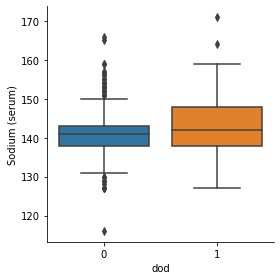

In [25]:
g = sns.catplot(x='dod',y='Sodium (serum)',data=test, kind="box",
                height=4, aspect=1);

# Description

# Logistic Regression

In [27]:
test[test.dod==0].shape[0]/test.shape[0]

0.7693798449612403

In [28]:
from sklearn.linear_model import LogisticRegression
X = test[['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp',
       'Verbal Response', 'Sodium (serum)', 'Chloride (serum)', 'Magnesium',
       'Creatinine (serum)']]
y = test['dod']
clf = LogisticRegression(random_state=0,max_iter=1000).fit(X, y)

clf.score(X, y)

0.8236434108527132

In [35]:
from sklearn.neighbors import NearestNeighbors

In [33]:

def MYknn(test_object, training_object, training_object_target, K):
    predictlist = []
    for newpoint in test_object:
        dataSetSize = training_object.shape[0]
        diffMat= np.tile(newpoint, (dataSetSize, 1)) - training_object
        sqDistances = (diffMat**2).sum(axis=1)
        distances = sqDistances ** 0.5
        sortedDistIndicies = distances.argsort()
        
        return sortedDistIndicies
        classCount = {}
        for i in range(K):
            voteIlabel = training_object_target[sortedDistIndicies[i]]
            classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1  #Get the value of key from the map and return 0 without key
            sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
            print(sortedClassCount)
            print(type(sortedClassCount))
        predictlist.append(sortedClassCount[0][0])
        
        return predictlist

In [34]:
MYknn( X_test_std, X_train_std, Y_train,10)

array([239, 308, 715, 107, 510,  94, 625, 751, 225, 709,   9, 106, 700,
        85, 591, 532, 304, 809, 637,  42, 452, 630, 156, 718, 422, 504,
        56, 549, 756, 431, 334, 574, 523,  30, 375, 567, 515, 426, 295,
        29, 792, 692, 507, 410, 627, 117, 439, 421, 192,  35, 216, 312,
       624, 698, 105,  70, 787, 564, 382, 705, 373, 220, 474, 740, 490,
        99, 427, 335, 506, 123, 575, 233, 165, 413, 675, 663, 282, 246,
       450, 581, 607, 807, 455, 736, 354, 180, 671, 386, 801, 350, 258,
       260, 273, 267,   7, 609, 425, 361, 389, 485, 131, 822, 726, 275,
        17, 696, 456, 769, 428, 493, 235, 160,  96, 540,  11, 301, 226,
       694, 701, 746,  49, 566, 660, 586, 217, 658, 232, 665, 475, 604,
        28,  44, 765, 785, 632,  82, 559, 569, 405, 416, 210, 277, 699,
       554, 548, 576, 790, 172, 483, 429, 502, 325, 727, 327, 438, 102,
       702, 621, 340,  68, 808, 221, 777,  21, 103, 362, 768,  69, 596,
       794, 593, 104, 654, 254, 813, 155,  13,  38, 496, 323,  1

In [30]:
## from sklearn.model_selection import train_test_split
from DS_MIMIC_knn import *
import numpy as np
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,random_state=40)  # the value will sa

std= StandardScaler()
X_train_std=std.fit_transform(X_train)
X_test_std=std.fit_transform(X_test)
My_knncomper_difftest(10, X_train_std, X_test_std, Y_train, Y_test)

KeyError: 239

---------------------
# Find dod ID


In [ ]:
raise TypeError

In [ ]:
# fillnan_test.set_index('subject_id',inplae=True)

In [ ]:
# dod_id=cohort[cohort['dod']==1]
# test = dod_id.join(fillnan_test,how='left')
# np.count_nonzero(test['stay_id']>1)

In [ ]:
dod_id

In [ ]:
test['stay_id']

# Load output event

In [ ]:
outevents = pd.read_csv('../data/icu/outputevents.csv')
itmes = pd.read_csv('../data/icu/d_items.csv')

In [ ]:
test_main = cohort.copy()

In [ ]:
out = outevents[outevents['subject_id'].isin(test_main.index)]

In [ ]:
for i in range(out.shape[0]):
    entry = out.iloc[i,:]
    sub_id, itemid = entry[['subject_id', 'itemid']]
    test_main.loc[sub_id, itemid] = entry['value']
test_main.head() 